<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_class_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf

In [23]:
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten
from tensorflow.keras import Sequential

In [24]:
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
GPU is NOT AVAILABLE


In [25]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)

In [27]:
def build_emotions():
    return image_dataset_from_directory(
                        f"drive/MyDrive/class_archive",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42,
                        shuffle=False)

In [28]:
emotions = build_emotions()

# Get the names of the labels
class_names = tuple(emotions.class_names)
print(class_names)

# Print the shape of the images
for image, label in emotions.take(1):
    print(image.shape)

Found 404 files belonging to 7 classes.
('angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised')
(1, 48, 48, 1)


In [29]:
# Preprocessing of the data

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)

emotions = emotions.map(lambda image, label: (preprocessing_model(image), label))

In [30]:
# Load the model
model = tf.keras.models.load_model('drive/MyDrive/efficientnet_v2_finetuning.keras')

# Show the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 4, 4, 1536)        12930622  
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 1024)              25166848  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [31]:
# Predict the labels of the test dataset
y_pred = model.predict(emotions, verbose=1)

# Get the loss and accuracy of the model on the test dataset
loss, accuracy = model.evaluate(emotions, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

404/404 [==============================] - 39s 82ms/step - loss: 3.2170 - accuracy: 0.3391
Test loss: 3.2170357704162598
Test accuracy: 0.3391089141368866


In [32]:
import pandas as pd

y_pred_df = pd.DataFrame(y_pred)

y_pred_csv_file = 'drive/MyDrive/y_pred_decimals.csv'
with open(y_pred_csv_file, mode='w') as f:
    y_pred_df.to_csv(f)

In [33]:
# Get the true labels of the test dataset
y_true = np.concatenate([y for x, y in emotions], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

In [34]:
#Produce a cm across all classes
def plot_confusion_matrix(cm, class_names):
    figure, ax = plt.subplots(figsize=(5, 5))
    cm_norm = cm / tf.reduce_sum(cm, axis=1)[:, None]
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'), vmin=0, vmax=1)
    accuracy_ = np.trace(cm) / float(np.sum(cm))
    ax.set_title(f'Accuracy: {100*accuracy_:.2f}%', fontsize=14, fontweight='bold')
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)


    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color='k')

    figure.tight_layout()
    plt.xlabel('Predicted', fontweight='bold', fontsize=14)
    plt.ylabel('True', fontweight='bold', fontsize=14)

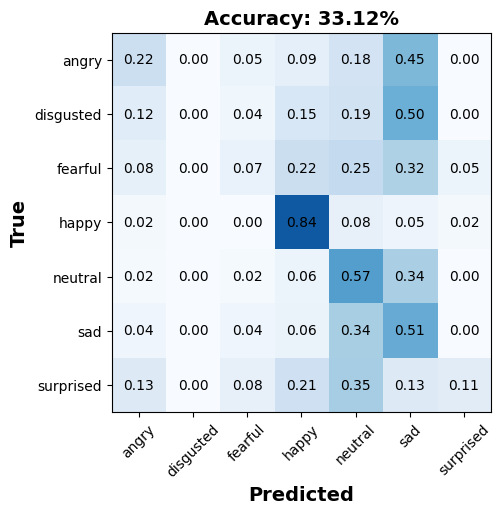

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')

plot_confusion_matrix(cm, class_names)

1/1 [==============================] - 5s 5s/step


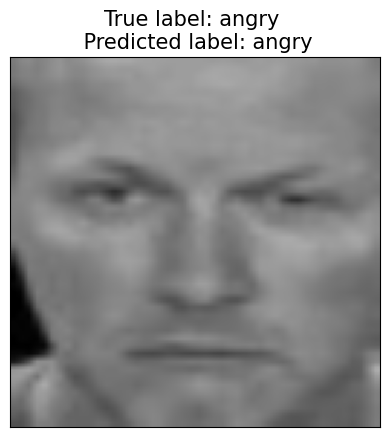

In [36]:
for image, label in emotions.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.title(f"True label: {class_names[np.argmax(label[0])]} \n Predicted label: {class_names[predicted_label[0]]}", fontsize=15)
    plt.show()


1/1 [==============================] - 0s 82ms/step


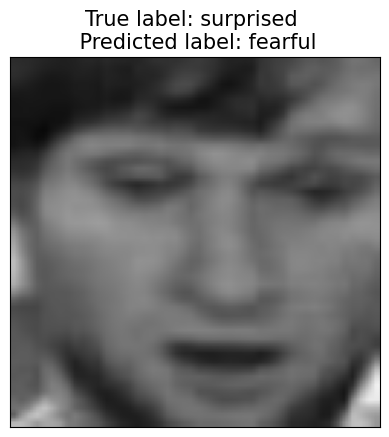

In [37]:
i = 0
for image, label in emotions.take(len(emotions)):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.title(f"True label: {class_names[np.argmax(label[0])]} \n Predicted label: {class_names[predicted_label[0]]}", fontsize=15)
    plt.savefig(f'drive/MyDrive/class_predictions/image{i}.png')
    i += 1